In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import zipfile
# with zipfile.ZipFile("/content/drive/MyDrive/Facial_Emotion/archive.zip") as f:
#   f.extractall('/content/drive/MyDrive/Facial_Emotion/')

In [3]:
import pandas as pd
df=pd.read_csv("/content/drive/MyDrive/Facial_Emotion/ckextended.csv")

In [4]:
df

,emotion,pixels,Usage
0,6,36 39 35 25 19 11 8 7 3 13 15 9 21 57 75 90 10...,Training
1,6,88 74 19 4 5 5 3 12 8 21 15 21 15 18 24 29 32 ...,Training
2,6,9 2 4 7 1 1 1 0 7 29 49 76 115 141 156 169 177...,Training
3,6,104 106 108 104 95 50 60 61 58 83 126 133 139 ...,Training
4,6,68 72 67 67 6 2 1 1 1 1 1 14 24 24 38 65 79 94...,Training
...,...,...,...
915,5,87 86 88 92 92 127 231 248 251 253 254 254 254...,PrivateTest
916,5,21 24 26 28 27 28 30 8 0 0 0 0 0 0 1 4 37 42 4...,PrivateTest
917,5,76 40 31 38 28 34 38 36 41 36 46 38 44 26 45 5...,PrivateTest
918,5,114 87 16 29 17 25 30 34 37 35 45 93 63 80 73 ...,PrivateTest


In [5]:
type(df.pixels[0])

str

In [6]:
df.isnull().sum()

,0
emotion,0
pixels,0
Usage,0


In [7]:
df.emotion.value_counts()

,count
emotion,
6,593
5,83
3,69
1,59
0,45
4,28
2,25
7,18


In [8]:

df.Usage.value_counts()

,count
Usage,
Training,734
PrivateTest,95
PublicTest,91


In [9]:
import numpy as np
X_train = []
y_train = []
X_test = []
y_test = []
for index, row in df.iterrows():
    k = row['pixels'].split(" ")
    if row['Usage'] == 'Training':
        X_train.append(np.array(k))
        y_train.append(row['emotion'])
    elif row['Usage'] == 'PublicTest':
        X_test.append(np.array(k))
        y_test.append(row['emotion'])

In [10]:
X_train[0].shape

(2304,)

In [11]:
import math
math.sqrt(2304)

48.0

In [12]:
X_train = np.array(X_train, dtype = 'uint8')
y_train = np.array(y_train, dtype = 'uint8')
X_test = np.array(X_test, dtype = 'uint8')
y_test = np.array(y_test, dtype = 'uint8')

In [13]:
X_train.shape

(734, 2304)

In [14]:
y_train.shape

(734,)

In [15]:
classes = np.unique(y_train)
classes

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=uint8)

In [16]:
print(y_train.dtype)
print(type(classes[0]))


uint8
<class 'numpy.uint8'>


In [17]:
X_augment=[]
Y_augment=[]
from collections import Counter
counts=Counter(y_train)
max_count = max(counts.values())
print(counts, "max:", max_count)


Counter({np.uint8(6): 474, np.uint8(5): 66, np.uint8(3): 55, np.uint8(1): 47, np.uint8(0): 36, np.uint8(4): 22, np.uint8(2): 20, np.uint8(7): 14}) max: 474


In [18]:
print(counts)

Counter({np.uint8(6): 474, np.uint8(5): 66, np.uint8(3): 55, np.uint8(1): 47, np.uint8(0): 36, np.uint8(4): 22, np.uint8(2): 20, np.uint8(7): 14})


In [19]:
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

In [20]:
X_train.shape

(734, 48, 48, 1)

In [21]:
X_train[y_train==1].shape

(47, 48, 48, 1)

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    # rescale=1./255,
    rotation_range = 10,
    horizontal_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode = 'nearest')

In [23]:
classes

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=uint8)

In [24]:
# X_train = (X_train/255.0).astype(np.float32)
# X_test = (X_train/255.0).astype(np.float32)

In [25]:
for c in classes:
    X_class = X_train[y_train == c]
    n_to_generate = max_count - len(X_class)

    if n_to_generate <= 0:
        X_augment.append(X_class)
        Y_augment.append(np.full(len(X_class), c))
        continue

    gen = datagen.flow(X_class, np.full(len(X_class), c), batch_size=1)

    generated_images = []
    generated_labels = []

    for _ in range(n_to_generate):
        x_batch, y_batch = next(gen)
        generated_images.append(x_batch[0])
        generated_labels.append(y_batch[0])
    X_class_all = np.concatenate([X_class, np.array(generated_images)], axis=0)
    y_class_all = np.concatenate([np.full(len(X_class), c), np.array(generated_labels)], axis=0)

    X_augment.append(X_class_all)
    Y_augment.append(y_class_all)


In [26]:
X_test_augment = []
y_test_augment = []
from collections import Counter
test_counts = Counter(y_test)
max_count_test = max(test_counts.values())
print(test_counts, "max:", max_count_test)


for c in classes:
    X_class_test = X_test[y_test == c]
    n_to_generate_test = max_count_test - len(X_class_test) # Use max_count_test here

    if n_to_generate_test <= 0:
        X_test_augment.append(X_class_test)
        y_test_augment.append(np.full(len(X_class_test), c))
        continue

    gen_test = datagen.flow(X_class_test, np.full(len(X_class_test), c), batch_size=1)

    generated_images_test = []
    generated_labels_test = []

    for _ in range(n_to_generate_test):
        x_batch_test, y_batch_test = next(gen_test)
        generated_images_test.append(x_batch_test[0])
        generated_labels_test.append(y_batch_test[0])

    X_class_all_test = np.concatenate([X_class_test, np.array(generated_images_test)], axis=0)
    y_class_all_test = np.concatenate([np.full(len(X_class_test), c), np.array(generated_labels_test)], axis=0)

    X_test_augment.append(X_class_all_test)
    y_test_augment.append(y_class_all_test)

X_test_balanced = np.concatenate(X_test_augment, axis=0)
y_test_balanced = np.concatenate(y_test_augment, axis=0)

print("Before test augmentation:", X_test.shape, y_test.shape)
print("After test augmentation:", X_test_balanced.shape, y_test_balanced.shape)

Counter({np.uint8(6): 59, np.uint8(5): 8, np.uint8(3): 7, np.uint8(1): 6, np.uint8(0): 4, np.uint8(4): 3, np.uint8(7): 2, np.uint8(2): 2}) max: 59
Before test augmentation: (91, 48, 48, 1) (91,)
After test augmentation: (472, 48, 48, 1) (472,)


In [27]:
59*8

472

In [28]:
X_balanced = np.concatenate(X_augment, axis=0)
y_balanced = np.concatenate(Y_augment, axis=0)

print("Before:", X_train.shape, y_train.shape)
print("After:", X_balanced.shape, y_balanced.shape)


Before: (734, 48, 48, 1) (734,)
After: (3792, 48, 48, 1) (3792,)


In [29]:
import numpy as np

# Duplicate the single channel to make it 3 channels
X_balanced_3_channel = np.repeat(X_balanced, 3, axis=-1)
X_test_3_channel = np.repeat(X_test_balanced, 3, axis=-1)

print(f"Original X_balanced shape: {X_balanced.shape}")
print(f"New X_balanced_3_channel shape: {X_balanced_3_channel.shape}")
print(f"Original X_test shape: {X_test.shape}")
print(f"New X_test_3_channel shape: {X_test_3_channel.shape}")

Original X_balanced shape: (3792, 48, 48, 1)
New X_balanced_3_channel shape: (3792, 48, 48, 3)
Original X_test shape: (91, 48, 48, 1)
New X_test_3_channel shape: (472, 48, 48, 3)


In [30]:
474*8

3792

In [31]:
y_balanced.shape

(3792,)

In [32]:
r=pd.DataFrame(y_balanced)

In [33]:
r.value_counts()

,count
0,
0,474
1,474
2,474
3,474
4,474
5,474
6,474
7,474


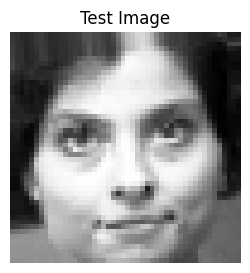

In [34]:
import random
from matplotlib import pyplot as plt
ix = random.randint(0, len(X_balanced) )

# Display the test image
plt.figure(figsize=(3, 3))
plt.subplot(1, 1, 1)
plt.imshow(X_balanced[ix],cmap='gray')
plt.title('Test Image')
plt.axis('off')
plt.show()

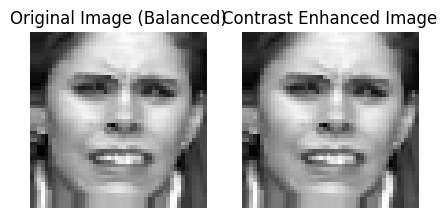

In [35]:
import numpy as np
from skimage import exposure
import matplotlib.pyplot as plt
idx = np.random.randint(0, len(X_balanced))
original_image = X_balanced[idx].copy()
contrasted_image = exposure.rescale_intensity(original_image, in_range='image')

plt.figure(figsize=(5, 5))

plt.subplot(1, 2, 1)
plt.imshow(original_image.squeeze(), cmap='gray')
plt.title('Original Image (Balanced)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(contrasted_image.squeeze(), cmap='gray')
plt.title('Contrast Enhanced Image')
plt.axis('off')

plt.show()


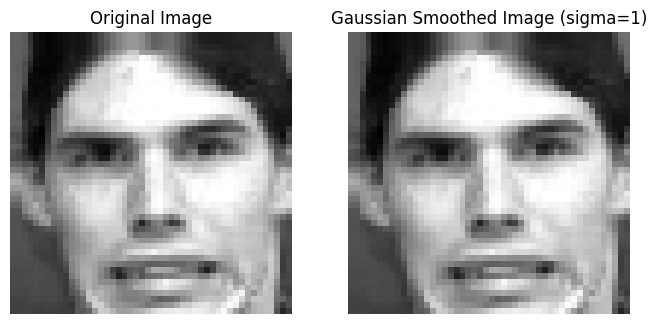

In [36]:
import numpy as np
from skimage.filters import gaussian
import matplotlib.pyplot as plt
idx = np.random.randint(0, len(X_balanced))
original_image = X_balanced[idx].copy()
smoothed_image = gaussian(original_image, sigma=0.3, preserve_range=True)

plt.figure(figsize=(8, 5))

plt.subplot(1, 2, 1)
plt.imshow(original_image.squeeze(), cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(smoothed_image.squeeze(), cmap='gray')
plt.title('Gaussian Smoothed Image (sigma=1)')
plt.axis('off')

plt.show()

In [37]:
X_balanced.shape

(3792, 48, 48, 1)

In [38]:
import os
model_path = os.path.join("/content/drive/MyDrive/Facial_Emotion/", "model.h5")
csv_path = os.path.join("/content/drive/MyDrive/Facial_Emotion/", "log.csv")

In [39]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input,Conv2D, MaxPooling2D, Multiply, Concatenate, UpSampling2D, Conv2D,Conv2DTranspose,Add,GlobalAveragePooling2D,Dense,BatchNormalization,add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

input_shape = (48, 48, 3)
inputs_for_encoder = Input(shape=input_shape, name="input_image_for_encoder")

encoder_temp = MobileNetV2(include_top=False, weights="imagenet", input_tensor=inputs_for_encoder, alpha=1.4)

encoder_model = Model(inputs=inputs_for_encoder, outputs=encoder_temp.output)
encoder_model.summary()

/tmp/ipython-input-800980653.py:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  encoder_temp = MobileNetV2(include_top=False, weights="imagenet", input_tensor=inputs_for_encoder, alpha=1.4)


17831080/17831080 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image_for_en… │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 24, 24,    │      1,296 │ input_image_for_… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 24, 24,    │        192 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 24, 24,    │          0 │ bn_Conv1[0][0]    │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 24, 24,    │        432 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 24, 24,    │        192 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 24, 24,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 24, 24,    │      1,152 │ expanded_conv_de… │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 24, 24,    │         96 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 24, 24,    │      3,456 │ expanded_conv_pr… │
│ (Conv2D)            │ 144)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 24, 24,    │        576 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 144)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 24, 24,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 144)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 25, 25,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 144)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 12, 12,    │      1,296 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 144)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 12, 12,    │        576 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 144)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 12, 12,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 144)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 12, 12,    │      4,608 │ block_1_depthwis

 Total params: 4,363,712 (16.65 MB)

 Trainable params: 4,315,776 (16.46 MB)

 Non-trainable params: 47,936 (187.25 KB)

In [41]:
if 'encoder_temp' in locals():
    print("Full layer names in encoder_temp:")
    for layer in encoder_temp.layers:
        print(layer.name)
else:
    print("Please run the previous cell to define 'encoder_temp' first.")

Full layer names in encoder_temp:
input_image_for_encoder
Conv1
bn_Conv1
Conv1_relu
expanded_conv_depthwise
expanded_conv_depthwise_BN
expanded_conv_depthwise_relu
expanded_conv_project
expanded_conv_project_BN
block_1_expand
block_1_expand_BN
block_1_expand_relu
block_1_pad
block_1_depthwise
block_1_depthwise_BN
block_1_depthwise_relu
block_1_project
block_1_project_BN
block_2_expand
block_2_expand_BN
block_2_expand_relu
block_2_depthwise
block_2_depthwise_BN
block_2_depthwise_relu
block_2_project
block_2_project_BN
block_2_add
block_3_expand
block_3_expand_BN
block_3_expand_relu
block_3_pad
block_3_depthwise
block_3_depthwise_BN
block_3_depthwise_relu
block_3_project
block_3_project_BN
block_4_expand
block_4_expand_BN
block_4_expand_relu
block_4_depthwise
block_4_depthwise_BN
block_4_depthwise_relu
block_4_project
block_4_project_BN
block_4_add
block_5_expand
block_5_expand_BN
block_5_expand_relu
block_5_depthwise
block_5_depthwise_BN
block_5_depthwise_relu
block_5_project
block_5_pr

In [40]:

kernel_initializer = 'he_uniform'

def conv_block_2D(x, filters, block_type, repeat=1, dilation_rate=3, size=3, padding='same'):
    result = x

    for i in range(0, repeat):

        if block_type == 'separated':
            result = separated_conv2D_block(result, filters, size=size, padding=padding)
        elif block_type == 'duckv2':
            result = duckv2_conv2D_block(result, filters, size=size)
        elif block_type == 'midscope':
            result = midscope_conv2D_block(result, filters)
        elif block_type == 'widescope':
            result = widescope_conv2D_block(result, filters)
        elif block_type == 'resnet':
            result = resnet_conv2D_block(result, filters, dilation_rate)
        elif block_type == 'conv':
            result = Conv2D(filters, (size, size),
                            activation='relu', kernel_initializer=kernel_initializer, padding=padding)(result)
        elif block_type == 'double_convolution':
            result = double_convolution_with_batch_normalization(result, filters, dilation_rate)

        else:
            return None

    return result


def duckv2_conv2D_block(x, filters, size):
    x = BatchNormalization(axis=-1)(x)
    x5 = conv_block_2D(x, filters, 'resnet', repeat=3)
    x4= conv_block_2D(x, filters, 'resnet', repeat=3)
    x7=add([x4,x5])
    x6 = separated_conv2D_block(x5, filters, size=6, padding='same')
    x8=separated_conv2D_block(x,filters, size=6, padding='same')
    x = add([x4, x5, x6,x7,x8])

    x = BatchNormalization(axis=-1)(x)

    return x


def separated_conv2D_block(x, filters, size=3, padding='same'):
    x = Conv2D(filters, (1, size), activation='relu', kernel_initializer=kernel_initializer, padding=padding)(x)

    x = BatchNormalization(axis=-1)(x)

    x = Conv2D(filters, (size, 1), activation='relu', kernel_initializer=kernel_initializer, padding=padding)(x)

    x = BatchNormalization(axis=-1)(x)

    return x


def midscope_conv2D_block(x, filters):
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=1)(x)

    x = BatchNormalization(axis=-1)(x)

    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=2)(x)

    x = BatchNormalization(axis=-1)(x)

    return x


def widescope_conv2D_block(x, filters):
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=1)(x)

    x = BatchNormalization(axis=-1)(x)

    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=2)(x)

    x = BatchNormalization(axis=-1)(x)

    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=3)(x)

    x = BatchNormalization(axis=-1)(x)

    return x


def resnet_conv2D_block(x, filters, dilation_rate=1):
    x1 = Conv2D(filters, (1, 1), activation='relu', kernel_initializer=kernel_initializer, padding='same',
                dilation_rate=dilation_rate)(x)

    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=dilation_rate)(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=dilation_rate)(x)
    x = BatchNormalization(axis=-1)(x)
    x_final = add([x, x1])

    x_final = BatchNormalization(axis=-1)(x_final)

    return x_final


def double_convolution_with_batch_normalization(x, filters, dilation_rate=1):
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=dilation_rate)(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=dilation_rate)(x)
    x = BatchNormalization(axis=-1)(x)

    return x

In [41]:
def Custom_cnn(input_shape):
    inputs = Input(shape=input_shape, name="input_image")
    encoder = MobileNetV2(include_top=False, weights="imagenet", input_tensor=inputs, alpha=1.4)
    E1 = encoder.get_layer("input_image").output
    E2 = encoder.get_layer("expanded_conv_depthwise_relu").output
    E3 = encoder.get_layer("block_1_expand_relu").output
    E4 = encoder.get_layer("block_2_expand_relu").output
    E5 = encoder.get_layer("block_4_expand_relu").output
    print(f'This is the shape of E1 {E1.shape}')
    print(f'This is the shape of E2 {E2.shape}')
    print(f'This is the shape of E3 {E3.shape}')
    print(f'This is the shape of E4 {E4.shape}')
    print(f'This is the shape of E5 {E5.shape}')



    E1=conv_block_2D(E1,256,'duckv2',repeat=1)
    E1=BatchNormalization(axis=-1)(E1)
    E_1=Conv2D(256,(3,3),padding='same',activation='relu',kernel_regularizer=l2(1e-3))(E1)
    E_1=BatchNormalization(axis=-1)(E_1)
    Down_E1 = MaxPooling2D((2, 2))(E_1)

    E1_E2_con = Concatenate()([Down_E1,E2])
    print(f'This is the shape of E1_E2_con {E1_E2_con.shape}')

    E2=Conv2D(256,(3,3),padding='same',activation='relu',kernel_regularizer=l2(1e-3))(E2)
    E2=BatchNormalization(axis=-1)(E2)
    # Down_E2 =MaxPooling2D((2, 2))(E2)

    E2_E3_con = Concatenate()([E2,E3])
    # E2_E3_con=BatchNormalization(axis=-1)(E2_E3_con)
    print(f'This is the shape of E2_E3_con {E2_E3_con.shape}')

    E3=Conv2D(256,(3,3),padding="same",activation='relu',kernel_regularizer=l2(1e-3))(E3)
    E3=BatchNormalization(axis=-1)(E3)
    Down_E3 = MaxPooling2D((2, 2))(E3)

    E3_E4_con = Concatenate()([Down_E3,E4])
    # E3_E4_con=BatchNormalization(axis=-1)(E3_E4_con)
    print(f'This is the shape of E3_E4_con {E3_E4_con.shape}')

    E4=Conv2D(256,(3,3),padding='same',activation='relu',kernel_regularizer=l2(1e-3))(E4)
    E4=BatchNormalization(axis=-1)(E4)
    Down_E4 = MaxPooling2D((2, 2))(E4)

    E4_E5_con = Concatenate()([Down_E4,E5])
    # E4_E5_con=BatchNormalization(axis=-1)(E4_E5_con)
    print(f'This is the shape of E4_E5_con {E4_E5_con.shape}')

    E5 = conv_block_2D(E5, 512, 'resnet', repeat=1)
    E5 = BatchNormalization(axis=-1)(E5)
    E1_E2_con=UpSampling2D(size=(2, 2))(E1_E2_con)
    E2_E3_con=UpSampling2D(size=(2, 2))(E2_E3_con)
    E3_E4_con=UpSampling2D(size=(4, 4))(E3_E4_con)
    E4_E5_con=UpSampling2D(size=(8, 8))(E4_E5_con)
    E5=UpSampling2D(size=(8, 8))(E5)
    E5=Concatenate()([E2_E3_con,E2_E3_con,E3_E4_con,E4_E5_con,E5])
    E5=BatchNormalization(axis=-1)(E5)
    print(f'This is the shape of E5 {E5.shape}')
    x = GlobalAveragePooling2D()(E5)
    x = BatchNormalization(axis=-1)(x)
    # x = Dense(1024, activation='relu')(x)
    # x = BatchNormalization(axis=-1)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Dense(8, activation='softmax')(x)
    model = Model(inputs, x , name = "Facial-Emotion")
    optimizer = Adam(learning_rate=10e-5)
    model.compile(optimizer=optimizer , loss='sparse_categorical_crossentropy', metrics= ['accuracy'])
    return model

model = Custom_cnn((48,48,3))
model.summary()

/tmp/ipython-input-4270598949.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  encoder = MobileNetV2(include_top=False, weights="imagenet", input_tensor=inputs, alpha=1.4)


This is the shape of E1 (None, 48, 48, 3)
This is the shape of E2 (None, 24, 24, 48)
This is the shape of E3 (None, 24, 24, 144)
This is the shape of E4 (None, 12, 12, 192)
This is the shape of E5 (None, 6, 6, 288)
This is the shape of E1_E2_con (None, 24, 24, 304)
This is the shape of E2_E3_con (None, 24, 24, 400)
This is the shape of E3_E4_con (None, 12, 12, 448)
This is the shape of E4_E5_con (None, 6, 6, 544)
This is the shape of E5 (None, 48, 48, 2304)


Model: "Facial-Emotion"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 24, 24,    │      1,296 │ input_image[0][0] │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 24, 24,    │        192 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 24, 24,    │          0 │ bn_Conv1[0][0]    │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 24, 24,    │        432 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 24, 24,    │        192 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 24, 24,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 24, 24,    │      1,152 │ expanded_conv_de… │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 24, 24,    │         96 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 24, 24,    │      3,456 │ expanded_conv_pr… │
│ (Conv2D)            │ 144)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 24, 24,    │        576 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 144)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 24, 24,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 144)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 25, 25,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 144)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 12, 12,    │      1,296 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 144)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 12, 12,    │        576 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 144)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 12, 12,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 144)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 12, 12,    │      4,608 │ block_1_depthwis

 Total params: 6,000,376 (22.89 MB)

 Trainable params: 5,981,352 (22.82 MB)

 Non-trainable params: 19,024 (74.31 KB)

In [42]:
from sklearn.utils import shuffle
X_balanced_3_channel, y_balanced = shuffle(X_balanced_3_channel, y_balanced, random_state=42)

In [43]:
# from sklearn.utils import shuffle
# X_balanced_1, y_balanced_1 = shuffle(X_balanced, y_balanced, random_state=42)

In [44]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=1e-12, verbose=1),
        CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True), # Increased patience and added restore_best_weights
    ]

In [48]:
results = model.fit(X_balanced_3_channel, y_balanced, validation_split=0.2, batch_size=32, epochs=200,callbacks=callbacks)
# results = model.fit(X_balanced_1, y_balanced_1, validation_split=0.2, batch_size=32, epochs=200,callbacks=callbacks)

Epoch 1/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.5781 - loss: 1.7608
Epoch 1: val_loss improved from inf to 7.16514, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 69s 389ms/step - accuracy: 0.5798 - loss: 1.7557 - val_accuracy: 0.1238 - val_loss: 7.1651 - learning_rate: 1.0000e-04
Epoch 2/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9687 - loss: 0.6050
Epoch 2: val_loss did not improve from 7.16514
95/95 ━━━━━━━━━━━━━━━━━━━━ 30s 57ms/step - accuracy: 0.9687 - loss: 0.6048 - val_accuracy: 0.1647 - val_loss: 7.5372 - learning_rate: 1.0000e-04
Epoch 3/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9897 - loss: 0.5047
Epoch 3: val_loss improved from 7.16514 to 6.41481, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.9896 - loss: 0.5045 - val_accuracy: 0.2503 - val_loss: 6.4148 - learning_rate: 1.0000e-04
Epoch 4/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9944 - loss: 0.4631
Epoch 4: val_loss did not improve from 6.41481
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.9944 - loss: 0.4630 - val_accuracy: 0.1897 - val_loss: 8.7304 - learning_rate: 1.0000e-04
Epoch 5/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9970 - loss: 0.4417
Epoch 5: val_loss did not improve from 6.41481
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9970 - loss: 0.4417 - val_accuracy: 0.2951 - val_loss: 7.9812 - learning_rate: 1.0000e-04
Epoch 6/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9968 - loss: 0.4246
Epoch 6: val_loss improved from 6.41481 to 6.36294, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - accuracy: 0.9967 - loss: 0.4246 - val_accuracy: 0.4071 - val_loss: 6.3629 - learning_rate: 1.0000e-04
Epoch 7/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9953 - loss: 0.4199
Epoch 7: val_loss improved from 6.36294 to 5.80740, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.9953 - loss: 0.4199 - val_accuracy: 0.4809 - val_loss: 5.8074 - learning_rate: 1.0000e-04
Epoch 8/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9957 - loss: 0.4019
Epoch 8: val_loss improved from 5.80740 to 4.36938, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9957 - loss: 0.4020 - val_accuracy: 0.5007 - val_loss: 4.3694 - learning_rate: 1.0000e-04
Epoch 9/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9954 - loss: 0.3924
Epoch 9: val_loss did not improve from 4.36938
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.9954 - loss: 0.3923 - val_accuracy: 0.4545 - val_loss: 4.4346 - learning_rate: 1.0000e-04
Epoch 10/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9992 - loss: 0.3680
Epoch 10: val_loss improved from 4.36938 to 3.57008, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.9992 - loss: 0.3679 - val_accuracy: 0.4743 - val_loss: 3.5701 - learning_rate: 1.0000e-04
Epoch 11/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9996 - loss: 0.3563
Epoch 11: val_loss improved from 3.57008 to 2.05753, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.9996 - loss: 0.3562 - val_accuracy: 0.6891 - val_loss: 2.0575 - learning_rate: 1.0000e-04
Epoch 12/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.3425
Epoch 12: val_loss improved from 2.05753 to 1.71768, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 1.0000 - loss: 0.3424 - val_accuracy: 0.7312 - val_loss: 1.7177 - learning_rate: 1.0000e-04
Epoch 13/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 1.0000 - loss: 0.3298
Epoch 13: val_loss improved from 1.71768 to 1.58634, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 1.0000 - loss: 0.3298 - val_accuracy: 0.7299 - val_loss: 1.5863 - learning_rate: 1.0000e-04
Epoch 14/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.3175
Epoch 14: val_loss improved from 1.58634 to 1.37580, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 1.0000 - loss: 0.3174 - val_accuracy: 0.7576 - val_loss: 1.3758 - learning_rate: 1.0000e-04
Epoch 15/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 1.0000 - loss: 0.3062
Epoch 15: val_loss improved from 1.37580 to 1.17652, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 1.0000 - loss: 0.3062 - val_accuracy: 0.7747 - val_loss: 1.1765 - learning_rate: 1.0000e-04
Epoch 16/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.2939
Epoch 16: val_loss improved from 1.17652 to 0.87644, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 1.0000 - loss: 0.2939 - val_accuracy: 0.8274 - val_loss: 0.8764 - learning_rate: 1.0000e-04
Epoch 17/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.2822
Epoch 17: val_loss improved from 0.87644 to 0.71609, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 1.0000 - loss: 0.2822 - val_accuracy: 0.8656 - val_loss: 0.7161 - learning_rate: 1.0000e-04
Epoch 18/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.2705
Epoch 18: val_loss improved from 0.71609 to 0.60719, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 1.0000 - loss: 0.2705 - val_accuracy: 0.8867 - val_loss: 0.6072 - learning_rate: 1.0000e-04
Epoch 19/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.2596
Epoch 19: val_loss did not improve from 0.60719
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 1.0000 - loss: 0.2596 - val_accuracy: 0.8841 - val_loss: 0.6756 - learning_rate: 1.0000e-04
Epoch 20/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.2485
Epoch 20: val_loss improved from 0.60719 to 0.54078, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 1.0000 - loss: 0.2485 - val_accuracy: 0.8893 - val_loss: 0.5408 - learning_rate: 1.0000e-04
Epoch 21/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9771 - loss: 0.3117
Epoch 21: val_loss did not improve from 0.54078
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.9768 - loss: 0.3124 - val_accuracy: 0.3465 - val_loss: 6.6299 - learning_rate: 1.0000e-04
Epoch 22/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9804 - loss: 0.2953
Epoch 22: val_loss did not improve from 0.54078
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.9804 - loss: 0.2952 - val_accuracy: 0.7365 - val_loss: 1.9478 - learning_rate: 1.0000e-04
Epoch 23/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9961 - loss: 0.2469
Epoch 23: val_loss did not improve from 0.54078
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9961 - loss: 0.2469 - val_accuracy: 0.7576 - val_loss: 1.6915 - learning_rate: 1.0000e-04
Epoch 24/200
94/95 

95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.9986 - loss: 0.2146 - val_accuracy: 0.8999 - val_loss: 0.5314 - learning_rate: 1.0000e-05
Epoch 27/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9996 - loss: 0.2121
Epoch 27: val_loss improved from 0.53144 to 0.43344, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.9996 - loss: 0.2121 - val_accuracy: 0.9289 - val_loss: 0.4334 - learning_rate: 1.0000e-05
Epoch 28/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.2114
Epoch 28: val_loss improved from 0.43344 to 0.36228, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 1.0000 - loss: 0.2113 - val_accuracy: 0.9499 - val_loss: 0.3623 - learning_rate: 1.0000e-05
Epoch 29/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9993 - loss: 0.2108
Epoch 29: val_loss improved from 0.36228 to 0.32194, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.9993 - loss: 0.2108 - val_accuracy: 0.9618 - val_loss: 0.3219 - learning_rate: 1.0000e-05
Epoch 30/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.2085
Epoch 30: val_loss improved from 0.32194 to 0.29144, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 1.0000 - loss: 0.2085 - val_accuracy: 0.9697 - val_loss: 0.2914 - learning_rate: 1.0000e-05
Epoch 31/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.2068
Epoch 31: val_loss improved from 0.29144 to 0.27753, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 1.0000 - loss: 0.2068 - val_accuracy: 0.9776 - val_loss: 0.2775 - learning_rate: 1.0000e-05
Epoch 32/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 1.0000 - loss: 0.2056
Epoch 32: val_loss improved from 0.27753 to 0.27005, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 1.0000 - loss: 0.2056 - val_accuracy: 0.9829 - val_loss: 0.2701 - learning_rate: 1.0000e-05
Epoch 33/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9990 - loss: 0.2076
Epoch 33: val_loss improved from 0.27005 to 0.26065, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.9990 - loss: 0.2075 - val_accuracy: 0.9842 - val_loss: 0.2606 - learning_rate: 1.0000e-05
Epoch 34/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.2034
Epoch 34: val_loss improved from 0.26065 to 0.26035, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 1.0000 - loss: 0.2034 - val_accuracy: 0.9855 - val_loss: 0.2603 - learning_rate: 1.0000e-05
Epoch 35/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.2023
Epoch 35: val_loss improved from 0.26035 to 0.25634, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 1.0000 - loss: 0.2023 - val_accuracy: 0.9868 - val_loss: 0.2563 - learning_rate: 1.0000e-05
Epoch 36/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9999 - loss: 0.2016
Epoch 36: val_loss improved from 0.25634 to 0.25324, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9999 - loss: 0.2016 - val_accuracy: 0.9895 - val_loss: 0.2532 - learning_rate: 1.0000e-05
Epoch 37/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.1994
Epoch 37: val_loss improved from 0.25324 to 0.24843, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 1.0000 - loss: 0.1994 - val_accuracy: 0.9908 - val_loss: 0.2484 - learning_rate: 1.0000e-05
Epoch 38/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9997 - loss: 0.1982
Epoch 38: val_loss improved from 0.24843 to 0.24394, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.9997 - loss: 0.1982 - val_accuracy: 0.9908 - val_loss: 0.2439 - learning_rate: 1.0000e-05
Epoch 39/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.1965
Epoch 39: val_loss improved from 0.24394 to 0.24140, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 1.0000 - loss: 0.1965 - val_accuracy: 0.9908 - val_loss: 0.2414 - learning_rate: 1.0000e-05
Epoch 40/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.1951
Epoch 40: val_loss improved from 0.24140 to 0.23859, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 1.0000 - loss: 0.1951 - val_accuracy: 0.9908 - val_loss: 0.2386 - learning_rate: 1.0000e-05
Epoch 41/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.1937
Epoch 41: val_loss improved from 0.23859 to 0.23728, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 1.0000 - loss: 0.1937 - val_accuracy: 0.9908 - val_loss: 0.2373 - learning_rate: 1.0000e-05
Epoch 42/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.1921
Epoch 42: val_loss improved from 0.23728 to 0.23553, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 1.0000 - loss: 0.1921 - val_accuracy: 0.9895 - val_loss: 0.2355 - learning_rate: 1.0000e-05
Epoch 43/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9999 - loss: 0.1906
Epoch 43: val_loss improved from 0.23553 to 0.23316, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.9999 - loss: 0.1906 - val_accuracy: 0.9895 - val_loss: 0.2332 - learning_rate: 1.0000e-05
Epoch 44/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.1890
Epoch 44: val_loss improved from 0.23316 to 0.23155, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 1.0000 - loss: 0.1890 - val_accuracy: 0.9895 - val_loss: 0.2316 - learning_rate: 1.0000e-05
Epoch 45/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.1872
Epoch 45: val_loss improved from 0.23155 to 0.22879, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 1.0000 - loss: 0.1872 - val_accuracy: 0.9895 - val_loss: 0.2288 - learning_rate: 1.0000e-05
Epoch 46/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.1857
Epoch 46: val_loss improved from 0.22879 to 0.22611, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 1.0000 - loss: 0.1856 - val_accuracy: 0.9908 - val_loss: 0.2261 - learning_rate: 1.0000e-05
Epoch 47/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.1838
Epoch 47: val_loss improved from 0.22611 to 0.22502, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 1.0000 - loss: 0.1838 - val_accuracy: 0.9895 - val_loss: 0.2250 - learning_rate: 1.0000e-05
Epoch 48/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.1818
Epoch 48: val_loss improved from 0.22502 to 0.22295, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 1.0000 - loss: 0.1818 - val_accuracy: 0.9895 - val_loss: 0.2229 - learning_rate: 1.0000e-05
Epoch 49/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.1800
Epoch 49: val_loss improved from 0.22295 to 0.22203, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 1.0000 - loss: 0.1800 - val_accuracy: 0.9895 - val_loss: 0.2220 - learning_rate: 1.0000e-05
Epoch 50/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.1781
Epoch 50: val_loss improved from 0.22203 to 0.21898, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 1.0000 - loss: 0.1781 - val_accuracy: 0.9881 - val_loss: 0.2190 - learning_rate: 1.0000e-05
Epoch 51/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.1760
Epoch 51: val_loss improved from 0.21898 to 0.21717, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 1.0000 - loss: 0.1760 - val_accuracy: 0.9895 - val_loss: 0.2172 - learning_rate: 1.0000e-05
Epoch 52/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.1741
Epoch 52: val_loss improved from 0.21717 to 0.21520, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 1.0000 - loss: 0.1741 - val_accuracy: 0.9908 - val_loss: 0.2152 - learning_rate: 1.0000e-05
Epoch 53/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.1719
Epoch 53: val_loss improved from 0.21520 to 0.21411, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 1.0000 - loss: 0.1719 - val_accuracy: 0.9908 - val_loss: 0.2141 - learning_rate: 1.0000e-05
Epoch 54/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.1707
Epoch 54: val_loss improved from 0.21411 to 0.20828, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 1.0000 - loss: 0.1707 - val_accuracy: 0.9895 - val_loss: 0.2083 - learning_rate: 1.0000e-05
Epoch 55/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.1677
Epoch 55: val_loss improved from 0.20828 to 0.20693, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 1.0000 - loss: 0.1677 - val_accuracy: 0.9908 - val_loss: 0.2069 - learning_rate: 1.0000e-05
Epoch 56/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.1662
Epoch 56: val_loss improved from 0.20693 to 0.20476, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 1.0000 - loss: 0.1661 - val_accuracy: 0.9895 - val_loss: 0.2048 - learning_rate: 1.0000e-05
Epoch 57/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.1634
Epoch 57: val_loss improved from 0.20476 to 0.20035, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 1.0000 - loss: 0.1634 - val_accuracy: 0.9908 - val_loss: 0.2004 - learning_rate: 1.0000e-05
Epoch 58/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.1606
Epoch 58: val_loss improved from 0.20035 to 0.19839, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 1.0000 - loss: 0.1606 - val_accuracy: 0.9908 - val_loss: 0.1984 - learning_rate: 1.0000e-05
Epoch 59/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.1584
Epoch 59: val_loss improved from 0.19839 to 0.19760, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 1.0000 - loss: 0.1584 - val_accuracy: 0.9908 - val_loss: 0.1976 - learning_rate: 1.0000e-05
Epoch 60/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.1557
Epoch 60: val_loss improved from 0.19760 to 0.19529, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 1.0000 - loss: 0.1557 - val_accuracy: 0.9895 - val_loss: 0.1953 - learning_rate: 1.0000e-05
Epoch 61/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.1533
Epoch 61: val_loss improved from 0.19529 to 0.19346, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 1.0000 - loss: 0.1533 - val_accuracy: 0.9895 - val_loss: 0.1935 - learning_rate: 1.0000e-05
Epoch 62/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.1510
Epoch 62: val_loss improved from 0.19346 to 0.19070, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 1.0000 - loss: 0.1510 - val_accuracy: 0.9895 - val_loss: 0.1907 - learning_rate: 1.0000e-05
Epoch 63/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.1483
Epoch 63: val_loss improved from 0.19070 to 0.18909, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 1.0000 - loss: 0.1482 - val_accuracy: 0.9881 - val_loss: 0.1891 - learning_rate: 1.0000e-05
Epoch 64/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.1456
Epoch 64: val_loss improved from 0.18909 to 0.18549, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 1.0000 - loss: 0.1456 - val_accuracy: 0.9895 - val_loss: 0.1855 - learning_rate: 1.0000e-05
Epoch 65/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.1428
Epoch 65: val_loss improved from 0.18549 to 0.18221, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 1.0000 - loss: 0.1428 - val_accuracy: 0.9895 - val_loss: 0.1822 - learning_rate: 1.0000e-05
Epoch 66/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.1401
Epoch 66: val_loss improved from 0.18221 to 0.17901, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 1.0000 - loss: 0.1401 - val_accuracy: 0.9881 - val_loss: 0.1790 - learning_rate: 1.0000e-05
Epoch 67/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.1377
Epoch 67: val_loss improved from 0.17901 to 0.17721, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 1.0000 - loss: 0.1377 - val_accuracy: 0.9908 - val_loss: 0.1772 - learning_rate: 1.0000e-05
Epoch 68/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.1350
Epoch 68: val_loss improved from 0.17721 to 0.17480, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 1.0000 - loss: 0.1350 - val_accuracy: 0.9895 - val_loss: 0.1748 - learning_rate: 1.0000e-05
Epoch 69/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.1322
Epoch 69: val_loss improved from 0.17480 to 0.17175, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 1.0000 - loss: 0.1322 - val_accuracy: 0.9908 - val_loss: 0.1718 - learning_rate: 1.0000e-05
Epoch 70/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.1292
Epoch 70: val_loss improved from 0.17175 to 0.16971, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 1.0000 - loss: 0.1292 - val_accuracy: 0.9908 - val_loss: 0.1697 - learning_rate: 1.0000e-05
Epoch 71/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.1271
Epoch 71: val_loss improved from 0.16971 to 0.16970, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 1.0000 - loss: 0.1271 - val_accuracy: 0.9895 - val_loss: 0.1697 - learning_rate: 1.0000e-05
Epoch 72/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.1238
Epoch 72: val_loss improved from 0.16970 to 0.16573, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 1.0000 - loss: 0.1238 - val_accuracy: 0.9895 - val_loss: 0.1657 - learning_rate: 1.0000e-05
Epoch 73/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.1213
Epoch 73: val_loss improved from 0.16573 to 0.16410, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 1.0000 - loss: 0.1213 - val_accuracy: 0.9881 - val_loss: 0.1641 - learning_rate: 1.0000e-05
Epoch 74/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.1183
Epoch 74: val_loss improved from 0.16410 to 0.15924, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 1.0000 - loss: 0.1183 - val_accuracy: 0.9881 - val_loss: 0.1592 - learning_rate: 1.0000e-05
Epoch 75/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.1159
Epoch 75: val_loss did not improve from 0.15924
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 1.0000 - loss: 0.1159 - val_accuracy: 0.9881 - val_loss: 0.1603 - learning_rate: 1.0000e-05
Epoch 76/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9998 - loss: 0.1132
Epoch 76: val_loss improved from 0.15924 to 0.15735, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.9997 - loss: 0.1131 - val_accuracy: 0.9895 - val_loss: 0.1573 - learning_rate: 1.0000e-05
Epoch 77/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.1101
Epoch 77: val_loss improved from 0.15735 to 0.15223, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 1.0000 - loss: 0.1101 - val_accuracy: 0.9895 - val_loss: 0.1522 - learning_rate: 1.0000e-05
Epoch 78/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.1077
Epoch 78: val_loss improved from 0.15223 to 0.14881, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 1.0000 - loss: 0.1077 - val_accuracy: 0.9895 - val_loss: 0.1488 - learning_rate: 1.0000e-05
Epoch 79/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.1050
Epoch 79: val_loss improved from 0.14881 to 0.14688, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 1.0000 - loss: 0.1050 - val_accuracy: 0.9881 - val_loss: 0.1469 - learning_rate: 1.0000e-05
Epoch 80/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.1024
Epoch 80: val_loss improved from 0.14688 to 0.14495, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 1.0000 - loss: 0.1024 - val_accuracy: 0.9895 - val_loss: 0.1449 - learning_rate: 1.0000e-05
Epoch 81/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.1000
Epoch 81: val_loss improved from 0.14495 to 0.14061, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 1.0000 - loss: 0.1000 - val_accuracy: 0.9895 - val_loss: 0.1406 - learning_rate: 1.0000e-05
Epoch 82/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.0972
Epoch 82: val_loss improved from 0.14061 to 0.13890, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 1.0000 - loss: 0.0972 - val_accuracy: 0.9895 - val_loss: 0.1389 - learning_rate: 1.0000e-05
Epoch 83/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.0946
Epoch 83: val_loss improved from 0.13890 to 0.13741, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 1.0000 - loss: 0.0946 - val_accuracy: 0.9895 - val_loss: 0.1374 - learning_rate: 1.0000e-05
Epoch 84/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.0920
Epoch 84: val_loss improved from 0.13741 to 0.13559, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 1.0000 - loss: 0.0920 - val_accuracy: 0.9895 - val_loss: 0.1356 - learning_rate: 1.0000e-05
Epoch 85/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.0893
Epoch 85: val_loss improved from 0.13559 to 0.13002, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 1.0000 - loss: 0.0893 - val_accuracy: 0.9895 - val_loss: 0.1300 - learning_rate: 1.0000e-05
Epoch 86/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.0872
Epoch 86: val_loss did not improve from 0.13002
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 1.0000 - loss: 0.0872 - val_accuracy: 0.9881 - val_loss: 0.1318 - learning_rate: 1.0000e-05
Epoch 87/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.0843
Epoch 87: val_loss improved from 0.13002 to 0.12868, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 1.0000 - loss: 0.0843 - val_accuracy: 0.9881 - val_loss: 0.1287 - learning_rate: 1.0000e-05
Epoch 88/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.0821
Epoch 88: val_loss did not improve from 0.12868
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 1.0000 - loss: 0.0821 - val_accuracy: 0.9868 - val_loss: 0.1297 - learning_rate: 1.0000e-05
Epoch 89/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9994 - loss: 0.0817
Epoch 89: val_loss did not improve from 0.12868
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.9994 - loss: 0.0817 - val_accuracy: 0.9855 - val_loss: 0.1319 - learning_rate: 1.0000e-05
Epoch 90/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9990 - loss: 0.0792
Epoch 90: val_loss did not improve from 0.12868
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.9990 - loss: 0.0792 - val_accuracy: 0.9868 - val_loss: 0.1317 - learning_rate: 1.0000e-05
Epoch 91/200
94/95 

95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 1.0000 - loss: 0.0764 - val_accuracy: 0.9908 - val_loss: 0.1217 - learning_rate: 1.0000e-05
Epoch 92/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 0.0748
Epoch 92: val_loss improved from 0.12174 to 0.11922, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 1.0000 - loss: 0.0748 - val_accuracy: 0.9908 - val_loss: 0.1192 - learning_rate: 1.0000e-05
Epoch 93/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.0732
Epoch 93: val_loss improved from 0.11922 to 0.11726, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 1.0000 - loss: 0.0732 - val_accuracy: 0.9908 - val_loss: 0.1173 - learning_rate: 1.0000e-05
Epoch 94/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0716
Epoch 94: val_loss did not improve from 0.11726
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 1.0000 - loss: 0.0716 - val_accuracy: 0.8379 - val_loss: 0.6291 - learning_rate: 1.0000e-05
Epoch 95/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.0701
Epoch 95: val_loss improved from 0.11726 to 0.11442, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 1.0000 - loss: 0.0701 - val_accuracy: 0.9908 - val_loss: 0.1144 - learning_rate: 1.0000e-05
Epoch 96/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0685
Epoch 96: val_loss improved from 0.11442 to 0.11329, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 1.0000 - loss: 0.0685 - val_accuracy: 0.9908 - val_loss: 0.1133 - learning_rate: 1.0000e-05
Epoch 97/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.0669
Epoch 97: val_loss improved from 0.11329 to 0.10963, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 1.0000 - loss: 0.0669 - val_accuracy: 0.9908 - val_loss: 0.1096 - learning_rate: 1.0000e-05
Epoch 98/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.0653
Epoch 98: val_loss did not improve from 0.10963
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 1.0000 - loss: 0.0653 - val_accuracy: 0.9895 - val_loss: 0.1112 - learning_rate: 1.0000e-05
Epoch 99/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.0637
Epoch 99: val_loss improved from 0.10963 to 0.10889, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - accuracy: 1.0000 - loss: 0.0637 - val_accuracy: 0.9908 - val_loss: 0.1089 - learning_rate: 1.0000e-05
Epoch 100/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0621
Epoch 100: val_loss improved from 0.10889 to 0.10522, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 1.0000 - loss: 0.0621 - val_accuracy: 0.9895 - val_loss: 0.1052 - learning_rate: 1.0000e-05
Epoch 101/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.0605
Epoch 101: val_loss improved from 0.10522 to 0.10406, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 1.0000 - loss: 0.0605 - val_accuracy: 0.9921 - val_loss: 0.1041 - learning_rate: 1.0000e-05
Epoch 102/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0593
Epoch 102: val_loss improved from 0.10406 to 0.10170, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 1.0000 - loss: 0.0593 - val_accuracy: 0.9895 - val_loss: 0.1017 - learning_rate: 1.0000e-05
Epoch 103/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.0575
Epoch 103: val_loss did not improve from 0.10170
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 1.0000 - loss: 0.0575 - val_accuracy: 0.9908 - val_loss: 0.1023 - learning_rate: 1.0000e-05
Epoch 104/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 0.0560
Epoch 104: val_loss improved from 0.10170 to 0.10055, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 1.0000 - loss: 0.0560 - val_accuracy: 0.9895 - val_loss: 0.1005 - learning_rate: 1.0000e-05
Epoch 105/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.0545
Epoch 105: val_loss improved from 0.10055 to 0.10023, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 1.0000 - loss: 0.0545 - val_accuracy: 0.9908 - val_loss: 0.1002 - learning_rate: 1.0000e-05
Epoch 106/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0530
Epoch 106: val_loss improved from 0.10023 to 0.09629, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 1.0000 - loss: 0.0530 - val_accuracy: 0.9908 - val_loss: 0.0963 - learning_rate: 1.0000e-05
Epoch 107/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.0515
Epoch 107: val_loss improved from 0.09629 to 0.09522, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 1.0000 - loss: 0.0515 - val_accuracy: 0.9908 - val_loss: 0.0952 - learning_rate: 1.0000e-05
Epoch 108/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.0501
Epoch 108: val_loss improved from 0.09522 to 0.09181, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 1.0000 - loss: 0.0501 - val_accuracy: 0.9908 - val_loss: 0.0918 - learning_rate: 1.0000e-05
Epoch 109/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.0486
Epoch 109: val_loss improved from 0.09181 to 0.09017, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 1.0000 - loss: 0.0486 - val_accuracy: 0.9908 - val_loss: 0.0902 - learning_rate: 1.0000e-05
Epoch 110/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.0473
Epoch 110: val_loss improved from 0.09017 to 0.08997, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 1.0000 - loss: 0.0473 - val_accuracy: 0.9908 - val_loss: 0.0900 - learning_rate: 1.0000e-05
Epoch 111/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.0458
Epoch 111: val_loss did not improve from 0.08997
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 1.0000 - loss: 0.0458 - val_accuracy: 0.9908 - val_loss: 0.0910 - learning_rate: 1.0000e-05
Epoch 112/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0445
Epoch 112: val_loss did not improve from 0.08997
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 1.0000 - loss: 0.0445 - val_accuracy: 0.9908 - val_loss: 0.0909 - learning_rate: 1.0000e-05
Epoch 113/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.0430
Epoch 113: val_loss improved from 0.08997 to 0.08685, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 1.0000 - loss: 0.0430 - val_accuracy: 0.9921 - val_loss: 0.0869 - learning_rate: 1.0000e-05
Epoch 114/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.0418
Epoch 114: val_loss improved from 0.08685 to 0.08412, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 1.0000 - loss: 0.0418 - val_accuracy: 0.9908 - val_loss: 0.0841 - learning_rate: 1.0000e-05
Epoch 115/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.0403
Epoch 115: val_loss did not improve from 0.08412
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 1.0000 - loss: 0.0403 - val_accuracy: 0.9881 - val_loss: 0.0902 - learning_rate: 1.0000e-05
Epoch 116/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.0390
Epoch 116: val_loss did not improve from 0.08412
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 1.0000 - loss: 0.0390 - val_accuracy: 0.9881 - val_loss: 0.0867 - learning_rate: 1.0000e-05
Epoch 117/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0377
Epoch 117: val_loss improved from 0.08412 to 0.08298, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 1.0000 - loss: 0.0377 - val_accuracy: 0.9908 - val_loss: 0.0830 - learning_rate: 1.0000e-05
Epoch 118/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.0365
Epoch 118: val_loss improved from 0.08298 to 0.07884, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 1.0000 - loss: 0.0365 - val_accuracy: 0.9921 - val_loss: 0.0788 - learning_rate: 1.0000e-05
Epoch 119/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.0352
Epoch 119: val_loss did not improve from 0.07884
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 1.0000 - loss: 0.0352 - val_accuracy: 0.9895 - val_loss: 0.0860 - learning_rate: 1.0000e-05
Epoch 120/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.0340
Epoch 120: val_loss did not improve from 0.07884
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 1.0000 - loss: 0.0339 - val_accuracy: 0.9895 - val_loss: 0.0826 - learning_rate: 1.0000e-05
Epoch 121/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 1.0000 - loss: 0.0328
Epoch 121: val_loss did not improve from 0.07884
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 1.0000 - loss: 0.0328 - val_accuracy: 0.9881 - val_loss: 0.0859 - learning_rate: 1.0000e-05
Epoch 122/200

95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 1.0000 - loss: 0.0306 - val_accuracy: 0.9908 - val_loss: 0.0757 - learning_rate: 1.0000e-06
Epoch 124/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.0306
Epoch 124: val_loss improved from 0.07567 to 0.07378, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 1.0000 - loss: 0.0306 - val_accuracy: 0.9908 - val_loss: 0.0738 - learning_rate: 1.0000e-06
Epoch 125/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0304
Epoch 125: val_loss improved from 0.07378 to 0.07356, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 1.0000 - loss: 0.0304 - val_accuracy: 0.9908 - val_loss: 0.0736 - learning_rate: 1.0000e-06
Epoch 126/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.0302
Epoch 126: val_loss improved from 0.07356 to 0.07345, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 1.0000 - loss: 0.0302 - val_accuracy: 0.9895 - val_loss: 0.0734 - learning_rate: 1.0000e-06
Epoch 127/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.0301
Epoch 127: val_loss improved from 0.07345 to 0.07302, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 1.0000 - loss: 0.0301 - val_accuracy: 0.9895 - val_loss: 0.0730 - learning_rate: 1.0000e-06
Epoch 128/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.0300
Epoch 128: val_loss did not improve from 0.07302
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 1.0000 - loss: 0.0300 - val_accuracy: 0.9895 - val_loss: 0.0732 - learning_rate: 1.0000e-06
Epoch 129/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.0299
Epoch 129: val_loss did not improve from 0.07302
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 1.0000 - loss: 0.0299 - val_accuracy: 0.9895 - val_loss: 0.0732 - learning_rate: 1.0000e-06
Epoch 130/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0297
Epoch 130: val_loss did not improve from 0.07302
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 1.0000 - loss: 0.0297 - val_accuracy: 0.9895 - val_loss: 0.0731 - learning_rate: 1.0000e-06
Epoch 131/200


Epoch 131: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 1.0000 - loss: 0.0296 - val_accuracy: 0.9895 - val_loss: 0.0729 - learning_rate: 1.0000e-06
Epoch 132/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.0295
Epoch 132: val_loss improved from 0.07293 to 0.07252, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 1.0000 - loss: 0.0295 - val_accuracy: 0.9895 - val_loss: 0.0725 - learning_rate: 1.0000e-07
Epoch 133/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.0295
Epoch 133: val_loss improved from 0.07252 to 0.07236, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 1.0000 - loss: 0.0295 - val_accuracy: 0.9895 - val_loss: 0.0724 - learning_rate: 1.0000e-07
Epoch 134/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.0295
Epoch 134: val_loss did not improve from 0.07236
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 1.0000 - loss: 0.0295 - val_accuracy: 0.9895 - val_loss: 0.0725 - learning_rate: 1.0000e-07
Epoch 135/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.0295
Epoch 135: val_loss did not improve from 0.07236
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 1.0000 - loss: 0.0295 - val_accuracy: 0.9895 - val_loss: 0.0725 - learning_rate: 1.0000e-07
Epoch 136/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0294
Epoch 136: val_loss did not improve from 0.07236
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 1.0000 - loss: 0.0294 - val_accuracy: 0.9895 - val_loss: 0.0724 - learning_rate: 1.0000e-07
Epoch 137/2


Epoch 137: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.
95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 1.0000 - loss: 0.0294 - val_accuracy: 0.9895 - val_loss: 0.0723 - learning_rate: 1.0000e-07
Epoch 138/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.0294
Epoch 138: val_loss did not improve from 0.07226
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 1.0000 - loss: 0.0294 - val_accuracy: 0.9895 - val_loss: 0.0723 - learning_rate: 1.0000e-08
Epoch 139/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.0294
Epoch 139: val_loss improved from 0.07226 to 0.07225, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 1.0000 - loss: 0.0294 - val_accuracy: 0.9895 - val_loss: 0.0723 - learning_rate: 1.0000e-08
Epoch 140/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.0294
Epoch 140: val_loss did not improve from 0.07225
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 1.0000 - loss: 0.0294 - val_accuracy: 0.9895 - val_loss: 0.0725 - learning_rate: 1.0000e-08
Epoch 141/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.0294
Epoch 141: val_loss improved from 0.07225 to 0.07225, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 1.0000 - loss: 0.0294 - val_accuracy: 0.9895 - val_loss: 0.0722 - learning_rate: 1.0000e-08
Epoch 142/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.0295
Epoch 142: val_loss improved from 0.07225 to 0.07222, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 1.0000 - loss: 0.0295 - val_accuracy: 0.9895 - val_loss: 0.0722 - learning_rate: 1.0000e-08
Epoch 143/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.0294
Epoch 143: val_loss did not improve from 0.07222

Epoch 143: ReduceLROnPlateau reducing learning rate to 9.999999939225292e-10.
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 1.0000 - loss: 0.0294 - val_accuracy: 0.9895 - val_loss: 0.0723 - learning_rate: 1.0000e-08
Epoch 144/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0294
Epoch 144: val_loss did not improve from 0.07222
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 1.0000 - loss: 0.0294 - val_accuracy: 0.9895 - val_loss: 0.0724 - learning_rate: 1.0000e-09
Epoch 145/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.0294
Epoch 145: val_loss improved from 0.07222 to 0.07203, saving model to /content/drive/MyDrive/Facial_Emotion/model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 1.0000 - loss: 0.0294 - val_accuracy: 0.9895 - val_loss: 0.0720 - learning_rate: 1.0000e-09
Epoch 146/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.0294
Epoch 146: val_loss did not improve from 0.07203
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 1.0000 - loss: 0.0294 - val_accuracy: 0.9895 - val_loss: 0.0722 - learning_rate: 1.0000e-09
Epoch 147/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 1.0000 - loss: 0.0294
Epoch 147: val_loss did not improve from 0.07203
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 1.0000 - loss: 0.0294 - val_accuracy: 0.9895 - val_loss: 0.0723 - learning_rate: 1.0000e-09
Epoch 148/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.0294
Epoch 148: val_loss did not improve from 0.07203
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 1.0000 - loss: 0.0294 - val_accuracy: 0.9895 - val_loss: 0.0724 - learning_rate: 1.0000e-09
Epoch 149/200

In [50]:
model.save_weights("/content/drive/MyDrive/Facial_Emotion/model_second_try.weights.h5") # Added .weights
print("Saved model to disk")

Saved model to disk


In [51]:
model_json = model.to_json()
with open("/content/drive/MyDrive/Facial_Emotion/model_part2.json", "w") as json_file:
    json_file.write(model_json)

In [47]:
from tensorflow.keras.models import model_from_json
model = model_from_json(open("/content/drive/MyDrive/Facial_Emotion/model_part2.json", "r").read())
model.load_weights("/content/drive/MyDrive/Facial_Emotion/model_second_try.weights.h5")

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 77 variables whereas the saved optimizer has 152 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [48]:

# Evaluate the loaded model on the test data
X_test_3 = np.repeat(X_test, 3, axis=-1)

loss, accuracy =model.evaluate(X_test_3, y_test)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8989 - loss: 0.3736
Test Loss: 0.5518
Test Accuracy: 0.8681


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
Classification Report on Balanced Test Set:
              precision    recall  f1-score   support

           0       1.00      0.25      0.40         4
           1       1.00      1.00      1.00         6
           2       0.00      0.00      0.00         2
           3       0.88      1.00      0.93         7
           4       1.00      0.67      0.80         3
           5       0.89      1.00      0.94         8
           6       0.90      0.92      0.91        59
           7       0.20      0.50      0.29         2

    accuracy                           0.87        91
   macro avg       0.73      0.67      0.66        91
weighted avg       0.88      0.87      0.86        91



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


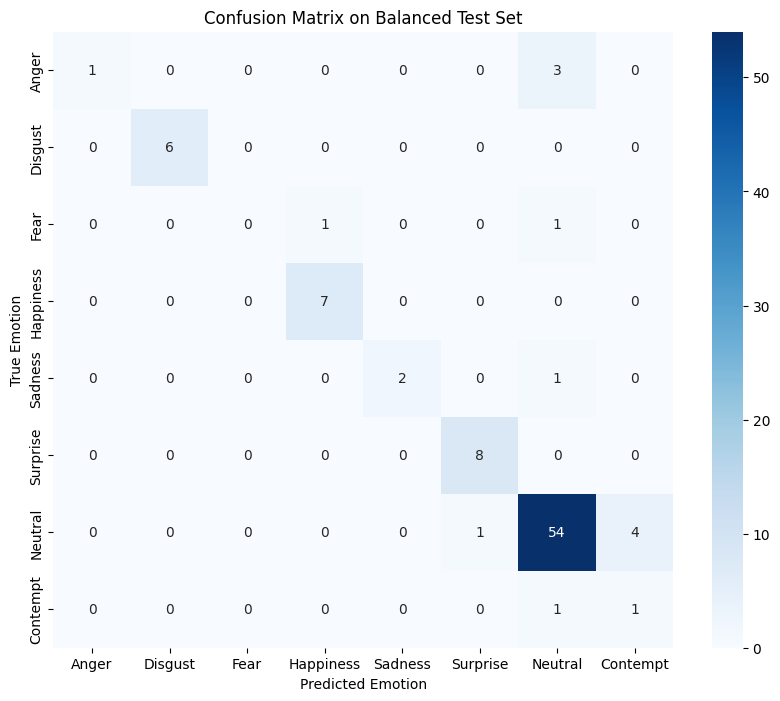

In [49]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions on the balanced test set
y_pred_balanced = model.predict(X_test_3)
y_pred_classes_balanced = np.argmax(y_pred_balanced, axis=1)

# Generate classification report for the balanced test set
print("Classification Report on Balanced Test Set:")
print(classification_report(y_test, y_pred_classes_balanced))

# Define emotion labels
emotion_labels = {
    0: 'Anger',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happiness',
    4: 'Sadness',
    5: 'Surprise',
    6: 'Neutral',
    7: 'Contempt'
}

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes_balanced)

# Plot confusion matrix with labels and colors
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_labels.values(),
            yticklabels=emotion_labels.values())
plt.xlabel('Predicted Emotion')
plt.ylabel('True Emotion')
plt.title('Confusion Matrix on Balanced Test Set')
plt.show()